<a href="https://colab.research.google.com/github/tararebaganimk3/test2/blob/main/BPM_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [62]:
#計算用
import numpy as np
import pandas as pd
from scipy.constants import pi
from scipy.sparse import diags, dia_matrix, csr_matrix
from scipy.sparse.linalg import spsolve
#計算時間計測
import time

#ゼロ除算回避
def avoid_0_division(numerator, denominator, delta):
    # ゼロ除算を回避するために、微小量を加える
    denominator = np.clip(denominator, delta, None)
    # ゼロ除算を回避した上での計算
    result = numerator / denominator
    return result

#透明境界条件つきでnp.roll関数を作用させる各種関数
def up_down(f, delta):
    f_up = np.roll(f, -1, axis=0) #f_up[-1, :]=f[0, :]で循環してしまう
    f_down = np.roll(f, 1, axis=0) #f_down[0, :]=f[-1, :]で循環してしまう
    #循環を回避して透明境界条件を適用
    f_up[-1, :] = f[-1, :] * avoid_0_division(f[-1, :], f[-2,:], delta)
    f_down[0, :] = f[0, :] * avoid_0_division(f[0, :], f[1, :], delta)
    return f_up, f_down
def left_right(f, delta):
    f_left = np.roll(f, -1, axis=1) #f_left[:, -1]=f[:, 0]で循環してしまう
    f_right = np.roll(f, 1, axis=1) #f_right[:, 0]=f[:, -1]で循環してしまう
    #循環を回避して透明境界条件を適用
    f_left[:, -1] = f[:, -1] * avoid_0_division(f[:, -1], f[:, -2], delta)
    f_right[:, 0] = f[:, 0] * avoid_0_division(f[:, 0], f[:, 1], delta)
    return f_left, f_right

#𝜕x^2をする関数
def round_x2(f, delta_x, delta):
    # 中心差分法を用いて二階偏微分を計算
    f_up, f_down = up_down(f, delta)
    result = (f_up - 2 * f + f_down) / (delta_x ** 2)
    return result

#𝜕y^2をする関数
def round_y2(f, delta_y, delta):
    # 中心差分法を用いて二階偏微分を計算
    f_left, f_right = left_right(f, delta)
    result = (f_left - 2 * f + f_right) / (delta_y ** 2)
    return result

#𝜕x𝜕yをする関数
def round_xy(f, delta_x, delta_y, delta):
    f_up, f_down = up_down(f, delta)    
    f_up_left, f_up_right = left_right(f_up, delta)
    f_down_left, f_down_right = left_right(f_down, delta)
    # 中心差分法を用いて二階偏微分を計算
    result = (f_up_left - f_up_right - f_down_left + f_down_right) / (4*delta_x*delta_y)
    return result

#𝜕x((𝜕xf1)/f2)をする関数
def round_x_round_x(f1, f2, delta_x, delta):
    f1_up, f1_down = up_down(f1, delta)
    f2_up, f2_down = up_down(f2, delta)
    # 中心差分法を用いて二階偏微分を計算
    result = 2 * ((f1_up - f1)/(f2_up + f2) - (f1 - f1_down)/(f2 + f2_down)) / (delta_x**2)   
    return result

#𝜕y((𝜕yf1)/f2)をする関数
def round_y_round_y(f1, f2, delta_y, delta):
    f1_left, f1_right = left_right(f1, delta)
    f2_left, f2_right = left_right(f2, delta)
    # 中心差分法を用いて二階偏微分を計算
    result = 2 * ((f1_left - f1)/(f2_left + f2) - (f1 - f1_right)/(f2_right + f2)) / (delta_y**2)
    return result

#𝜕x((𝜕yf1)/f2)をする関数
def round_x_round_y(f1, f2, delta_x, delta_y, delta):
    f1_up, f1_down = up_down(f1, delta)
    f2_up, f2_down = up_down(f2, delta)
    f1_left, f1_right = left_right(f1, delta) 
    f1_up_left, f1_up_right = left_right(f1_up, delta)
    f1_down_left, f1_down_right = left_right(f1_down, delta)  
    # 中心差分法を用いて二階偏微分を計算
    result = ((f1_up_left + f1_left - f1_up_right - f1_right)/(f2_up + f2)
    - (f1_left + f1_down_left - f1_right - f1_down_right)/(f2 + f2_down)) / (2*delta_x*delta_y)   
    return result

#𝜕y((𝜕xf1)/f2)をする関数
def round_y_round_x(f1, f2, delta_x, delta_y, delta):
    f1_up, f1_down = up_down(f1, delta)
    f1_left, f1_right = left_right(f1, delta)
    f2_left, f2_right = left_right(f2, delta)
    f1_up_left, f1_up_right = left_right(f1_up, delta)
    f1_down_left, f1_down_right = left_right(f1_down, delta)
    # 中心差分法を用いて二階偏微分を計算
    result = ((f1_up_left + f1_up - f1_down_left - f1_down)/(f2_left + f2)
    - (f1_up + f1_up_right - f1_down - f1_down_right)/(f2 + f2_right)) / (2*delta_x*delta_y) 
    return result

#三重対角行列を作成＆計算
def tridiagonal_matrix_quarter(f, C, a, b, c, delta):
    N = f.shape[0]
    main_diag = np.empty(N, dtype = complex)
    sub_diag = np.empty(N - 1, dtype = complex)
    sup_diag = np.empty(N - 1, dtype = complex)
    for j in range(N):
        for i in range(N):
            if i == 0:
                main_diag[i] = b[i][j] + a[i][j] * avoid_0_division(f[0, j], f[1, j], delta)
                sup_diag[i] = c[i][j]
            elif i == N - 1:
                sub_diag[i - 1] = a[i][j]
                main_diag[i] = b[i][j] + c[i][j] * avoid_0_division(f[-1, j], f[-2, j], delta)
            else:
                sub_diag[i - 1] = a[i][j]
                main_diag[i] = b[i][j]
                sup_diag[i] = c[i][j]
        diagonals = [sub_diag.copy(), main_diag.copy(), sup_diag.copy()]  # .copy()を追加して、元の配列とは別の新しい配列を参照するようにします。
        diags_idx = [-1, 0, 1]
        A = diags(diagonals, diags_idx, (N, N), format='csr')
        result = spsolve(A, C[:, j])
        f[:, j] = result
    return f.astype(complex)

#計算領域生成
def create_mesh(nx, r, multiple):
    x = np.linspace(-r * multiple / 2, r * multiple / 2, nx)
    y = np.linspace(-r * multiple / 2, r * multiple / 2, nx)
    delta_x = r * multiple / nx
    mesh_x, mesh_y = np.meshgrid(x, y, indexing='ij')
    return mesh_x, mesh_y, delta_x

#誘電率分布生成
def generate_eps(mesh_x, mesh_y, index_core_x, index_core_y, delta_n, r):
    nx = mesh_x.shape[0]
    delta_x = mesh_x[1, 0] - mesh_x[0, 0]
    
    if index_core_x >= index_core_y:
        index_clad = index_core_y * np.sqrt(1-2*delta_n/100)
    else:
        index_clad = index_core_x * np.sqrt(1-2*delta_n/100)
    eps_distribution_x = np.full((nx, nx), index_clad**2, dtype=complex)
    eps_distribution_y = np.full((nx, nx), index_clad**2, dtype=complex)

    center_x, center_y = mesh_x[(nx - 1) // 2, (nx - 1) // 2], mesh_y[(nx - 1) // 2, (nx - 1) // 2]
    
    # メッシュ上の座標とセンター座標との距離を計算
    dist = np.sqrt((mesh_x - center_x)**2 + (mesh_y - center_y)**2)
    
    # コア領域に対応する条件を満たす要素を更新
    eps_distribution_x[dist <= r] = index_core_x**2
    eps_distribution_y[dist <= r] = index_core_y**2

    return eps_distribution_x.astype(complex), eps_distribution_y.astype(complex), index_clad.astype(complex)

#初期電場生成
def generate_initial_gaussian_beam(mesh_x, mesh_y, polarization_angle, r, phase_shift):
    nx = mesh_x.shape[0]
    Ex = np.zeros((nx, nx), dtype=complex) 
    Ey = np.zeros((nx, nx), dtype=complex)
    
    # ガウシアンビームパラメータ
    beam_radius = r
    amplitude = 1.0
    # 中心からの距離を計算
    R_squared = mesh_x**2 + mesh_y**2
    # ガウシアンビーム強度分布生成
    intensity = amplitude * np.exp(-R_squared / (beam_radius**2))
    # 偏光方位をラジアン単位に変換
    polarization_angle_rad = np.deg2rad(polarization_angle)
    # 偏光方位に応じた入射光電場を生成
    Ex = intensity * np.cos(polarization_angle_rad) * np.exp(1j * phase_shift)
    Ey = intensity * np.sin(polarization_angle_rad) * np.exp(1j * phase_shift)

    threshold = 1e-8
    Ex[np.isclose(Ex, 0, atol=threshold)] = 0
    Ey[np.isclose(Ey, 0, atol=threshold)] = 0
        
    return Ex.astype(complex), Ey.astype(complex)

#全体をまとめたもの
def calculate(wavelength, nx, polarization_angle, delta_z, index_core_x, index_core_y, delta_n, r, iteration, multiple, phase_shift, record_interval: int, delta: int):
    #計測スタート
    start_time = time.time()
    #実行するたび初期化
    Ex = None
    Ey = None
    eps_x = None
    eps_y = None
    results = np.zeros((iteration // record_interval, 2, nx, nx), dtype = complex)
    delta = 10**(-delta)
    
    #パラメータをum単位からm単位に戻す
    wavelength *= 1e-6
    delta_z *= 1e-6
    r *= 1e-6
    #計算領域定義
    mesh_x, mesh_y, delta_x = create_mesh(nx, r, multiple)
    # 入射光生成
    Ex, Ey = generate_initial_gaussian_beam(mesh_x, mesh_y, polarization_angle, r, phase_shift)
    #誘電率分布生成
    eps_x, eps_y, index_clad = generate_eps(mesh_x, mesh_y, index_core_x, index_core_y, delta_n, r)
    
    #一貫した変数をあらかじめ定義
    eps_x_up, eps_x_down = up_down(eps_x, delta)
    eps_y_up, eps_y_down = up_down(eps_y, delta)
    k0 = 2 * pi / wavelength
    nf = index_clad
    sigma = delta_z / (2*1j*k0*nf)

    #ビーム伝搬法
    def beam_propagation_method(wavelength, eps_x, eps_y, nf, sigma, delta_x, delta_z, Ex, Ey):

        #スカラー変数を単位行列に変換
        nf = nf * np.ones((nx, nx), dtype=complex)
        sigma = sigma * np.ones((nx, nx), dtype=complex)
      
        #l+1/4の計算の右辺項
        def generate_tridiagonal_matrix_elements_quarter_right(nf, Ex, Ey):
            Cxx = k0**2 * (eps_x - nf**2) * Ex /2 + round_y2(Ex, delta_x, delta)
            Cyy = k0**2 * (eps_y - nf**2) * Ey /2 + round_y_round_y(Ey * eps_y, eps_y, delta_x, delta)
            C_x = Ex + sigma * Cxx / 2
            C_y = Ey + sigma * Cyy / 2
            return C_x.astype(complex), C_y.astype(complex)

        #l+1/2の計算の右辺項
        def generate_tridiagonal_matrix_elements_half_right(nf, Ex, Ey):
            Bxx = k0**2 * (eps_x - nf**2) * Ex /2 + round_x_round_x(Ex*eps_x, eps_x, delta_x, delta)
            Byy = k0**2 * (eps_y - nf**2) * Ey /2 + round_x2(Ey, delta_x, delta)
            B_x = Ex + sigma * Bxx / 2
            B_y = Ey + sigma * Byy / 2
            return B_x.astype(complex), B_y.astype(complex)
        
        #l+1/4の計算の左辺項
        def generate_tridiagonal_matrix_elements_quarter_left(nf):
            a_x = - (eps_x_down / (eps_x + eps_x_down)) * (sigma / delta_x**2)
            b_x = 1 - sigma * k0**2 * (eps_x - nf**2) / 4 + eps_x * ((1 / (eps_x_up + eps_x)) + (1 / (eps_x + eps_x_down))) * (sigma / delta_x**2)
            c_x = - (eps_x_up / (eps_x_up + eps_x)) * (sigma / delta_x**2)
            a_y = - (sigma / delta_x**2)
            b_y = 1 - sigma * k0**2 * (eps_y - nf**2) / 4 + (sigma / delta_x**2)
            c_y = - (sigma / delta_x**2)
            return a_x.astype(complex), b_x.astype(complex), c_x.astype(complex), a_y.astype(complex), b_y.astype(complex), c_y.astype(complex)

        #l+1/2の計算の左辺項
        def generate_tridiagonal_matrix_elements_half_left(nf):
            A_x = - (sigma / delta_x**2)
            B_x = 1 - sigma * k0**2 * (eps_x - nf**2) / 4 + (sigma / delta_x**2)
            C_x = - (sigma / delta_x**2)
            A_y = - (eps_y_down / (eps_y + eps_y_down)) * (sigma / delta_x**2)
            B_y = 1 - sigma * k0**2 * (eps_y - nf**2) / 4 + eps_y * ((1 / (eps_y_up + eps_y)) + (1 / (eps_y + eps_y_down))) * (sigma / delta_x**2)
            C_y = - (eps_y_up / (eps_y_up + eps_y)) * (sigma / delta_x**2)
            return A_x.astype(complex), B_x.astype(complex), C_x.astype(complex), A_y.astype(complex), B_y.astype(complex), C_y.astype(complex)
        
        #l+1/4の計算
        #右辺項
        C_x, C_y = generate_tridiagonal_matrix_elements_quarter_right(nf, Ex, Ey)

        #左辺項
        a_x, b_x, c_x, a_y, b_y, c_y = generate_tridiagonal_matrix_elements_quarter_left(nf)

        #Ex, Eyを更新
        Ex = tridiagonal_matrix_quarter(Ex, C_x, a_x, b_x, c_x, delta)
        Ey = tridiagonal_matrix_quarter(Ey, C_y, a_y, b_y, c_y, delta)

        #l+1/2の計算
        #右辺項
        B_x, B_y = generate_tridiagonal_matrix_elements_half_right(nf, Ex, Ey)

        #左辺項
        aa_x, bb_x, cc_x, aa_y, bb_y, cc_y = generate_tridiagonal_matrix_elements_half_left(nf)

        #Ex, Eyを更新
        Ex = tridiagonal_matrix_quarter(Ex.T, B_x.T, aa_x.T, bb_x.T, cc_x.T, delta).T
        Ey = tridiagonal_matrix_quarter(Ey.T, B_y.T, aa_y.T, bb_y.T, cc_y.T, delta).T

        #delta_n > 1ならばl+3/4とl+1の計算し，Ex，Eyを更新する
        if delta_n > 1:
          def update_field(nf, Ex, Ey):
              #l+1/2のExとEyからl+3/4のExを計算
              Cxy = round_x_round_y(Ey * eps_y, eps_x, delta_x, delta_x, delta) - round_xy(Ey, delta_x, delta_x, delta) * (eps_y / eps_x)
              Ex += Cxy * sigma / 2
              #l+1/2のEyとl+3/4のExからl+3/4のEyを計算
              Byx = round_y_round_x(Ex * eps_x, eps_y, delta_x, delta_x, delta) - round_xy(Ex, delta_x, delta_x, delta) * (eps_x / eps_y)    
              Ey += Byx * sigma / 2 
              #l+3/4のExとEyからl+1のEyを計算
              Byx = round_y_round_x(Ex * eps_x, eps_y, delta_x, delta_x, delta) - round_xy(Ex, delta_x, delta_x, delta) * (eps_x / eps_y)
              Ey += Byx * sigma / 2
              #l+1のEyとl+3/4のExからl+1のExを計算
              Cxy = round_x_round_y(Ey * eps_y, eps_x, delta_x, delta_x, delta) - round_xy(Ey, delta_x, delta_x, delta) * (eps_y / eps_x)
              Ex += Cxy * sigma / 2
              return Ex.astype(complex), Ey.astype(complex)
          
          Ex, Ey = update_field(nf, Ex, Ey)
        
        return Ex.astype(complex), Ey.astype(complex)

    # 計算の実行
    for i in range(int(iteration)):
        Ex, Ey = beam_propagation_method(wavelength, eps_x, eps_y, nf, sigma, delta_x, delta_z, Ex, Ey)
        # 一定間隔でデータを記録
        if i % record_interval == 0:
            results[i // record_interval, 0] = Ex
            results[i // record_interval, 1] = Ey
    pd.DataFrame(Ex.real).to_csv('Ex_real.csv')
    pd.DataFrame(Ex.imag).to_csv('Ex_imag.csv')
    #計測終了
    end_time = time.time()
    total_time = end_time - start_time
    print(f"実行時間: {total_time}秒")
    
    #最適化用
    print(r*multiple)
    print(delta_z)
    print(delta_x)

    return results, Ex, Ey, eps_x, eps_y, delta_x

In [75]:
#パラメータ
wavelength = 1.55 #@param {type:"number"}
nx = 50 #@param {type:"slider", min:10, max:150, step:10}
polarization_angle = 0 #@param {type:"slider",min:0, max:180, step:45}
delta_z = 0.005 #@param {type:"slider",min:0.005, max:0.05, step:0.0025}
index_core_x = 1.6 #@param {type:"number"}
index_core_y = 1.6 #@param {type:"number"}
delta_n = 1 #@param {type:"slider",min:0.2, max:10, step:0.2} 
r = 1.5 #@param {type:"slider",min:1, max:10, step:0.5}
iteration = 1000 #@param {type:"slider",min:10, max:1000, step:10}
multiple = 5 #@param {type:"slider",min:5, max:10, step:1}
phase_shift = 0 #@param {type:"slider",min:0, max:180, step:45}
record_interval = 1 #@param {type:"slider",min:1, max:10, step:1}
delta = 20 #@param {type:"slider",min:5, max:20, step:1}

#計算
results, Ex, Ey, eps_x, eps_y, delta_x = calculate(wavelength, nx, polarization_angle, delta_z, index_core_x, index_core_y, 
                                                   delta_n, r, iteration, multiple, phase_shift, record_interval, delta)



実行時間: 142.58838510513306秒
7.5e-06
5e-09
1.5e-07


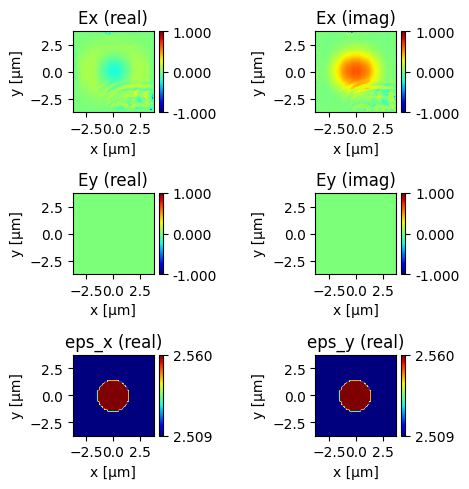

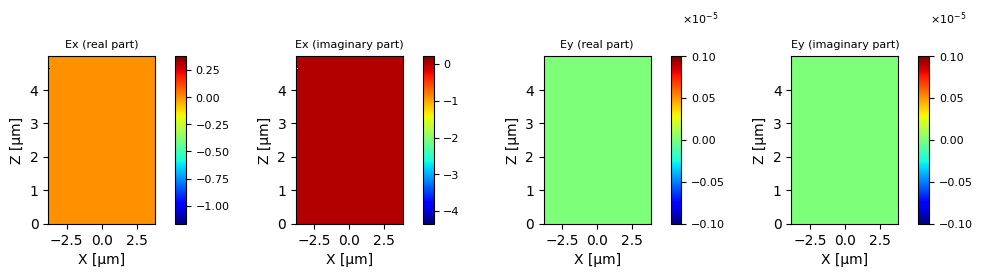

In [76]:
#グラフ表示用
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.ticker as ticker
from matplotlib.ticker import FuncFormatter, FixedLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable

#fig1
fig1, axs1 = plt.subplots(3, 2, figsize=(5, 5))
data = np.array([Ex.real, Ex.imag, Ey.real, Ey.imag, eps_x.real, eps_y.real])
titles = ['Ex (real)', 'Ex (imag)', 'Ey (real)', 'Ey (imag)', 'eps_x (real)', 'eps_y (real)']
vmin = [d.min() for d in data]
vmax = [d.max() for d in data]
for i, ax in enumerate(axs1.flatten()):
    if i <= 3:
      im = ax.imshow(data[i], cmap='jet', origin='lower', extent=(-r*multiple/2, r*multiple/2, -r*multiple/2, r*multiple/2), vmin = -1, vmax = 1)
      ax.set_title(titles[i])
      divider = make_axes_locatable(ax)
      cax = divider.append_axes("right", size="5%", pad=0.05)
      cb = plt.colorbar(im, cax=cax, format='%.3f')
      
    # 特定の値を目盛りに追加する
    if i >= 4:
        im = ax.imshow(data[i], cmap='jet', origin='lower', extent=(-r*multiple/2, r*multiple/2, -r*multiple/2, r*multiple/2), vmin = vmin[i], vmax = vmax[i])
        ax.set_title(titles[i])
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        cb = plt.colorbar(im, cax=cax, format='%.3f')  
        eps_max = vmax[i]
        eps_min = vmin[i]
        eps_ticks = [eps_min, eps_max]
        cb.ax.yaxis.set_ticks(eps_ticks)
        # 目盛りに表示する数値の書式を指定する
        formatter = ticker.FormatStrFormatter('%.3f')
        cb.ax.yaxis.set_major_formatter(formatter)

    ax.set_xlabel('x [µm]')
    ax.set_ylabel('y [µm]')
plt.tight_layout()

#fig2
fig2, axs2 = plt.subplots(1, 4, figsize=(10, 3))
mesh_x, mesh_y, delta_x = create_mesh(nx, r, multiple)
X = mesh_x[:, int(nx / 2)]
Z = np.arange(0, len(results)) * delta_z * record_interval

X, Z = np.meshgrid(X, Z)
Ex_real = np.array([np.real(result[0])[:, int(nx / 2)] for result in results])
Ex_imag = np.array([np.imag(result[0])[:, int(nx / 2)] for result in results])
Ey_real = np.array([np.real(result[1])[:, int(nx / 2)] for result in results])
Ey_imag = np.array([np.imag(result[1])[:, int(nx / 2)] for result in results])

titles = ['Ex (real part)', 'Ex (imaginary part)', 'Ey (real part)', 'Ey (imaginary part)']
data = [Ex_real, Ex_imag, Ey_real, Ey_imag]

for i, ax in enumerate(axs2.flat):
    c = ax.pcolormesh(X, Z, data[i], cmap='jet', shading='auto', vmin=np.min(data[i]), vmax=np.max(data[i]))
    
    # Create an axis on the right side of the plot for the colorbar
    divider = make_axes_locatable(ax)
    # size: カラーバーのグラフに対する横幅, pad: カラーバーとグラフの間隔を調節
    cax = divider.append_axes("right", size="10%", pad=0.2)
    
    # カラーバーの横幅を変更
    cb = fig2.colorbar(c, cax=cax)
    # カラーバーの数値のフォントサイズを変更
    cb.ax.tick_params(labelsize=8)

    # カラーバーの上部に表示される値のフォントサイズと表示を調整
    cb.ax.yaxis.get_offset_text().set_visible(True)
    cb.ax.yaxis.offsetText.set_visible(False)
    if i >=2:
      cb.ax.text(1.1, 1.2, r'$\times 10^{-5}$', transform=cb.ax.transAxes, fontsize=8)

    #軸ラベル
    ax.set_xlabel('X [µm]')
    ax.set_ylabel('Z [µm]')
    # タイトルのフォントサイズを変更
    ax.set_title(titles[i], fontsize = 8)

# プロットを表示
plt.tight_layout()
fig2.subplots_adjust(wspace=0.8)  # グラフ同士の間隔を調整する
plt.show()


In [ ]:
for i in range(1,1000,1):
    x = 1/np.float32(10**i)
    y = 1/np.float64(10**i)
    if x == 0:
        print('ここで0除算になります:', i)
        break
    else:
        print(x)
        if x != y:
          print('誤差発生．誤差=', abs(x-y)/y)

In [ ]:
# float型の最大値を求める
max_float = np.finfo(np.float32).max
print(f"float型の最大値: {max_float:.10g}")

# float型の最小値を求める
min_float = np.finfo(np.float32).tiny
print(f"float型の最小値: {min_float:.10g}")

# float型の精度を確認する
x = np.float32(1) / np.float32(3)
print(f"1/3をfloat型で表現すると: {x:.20f}")

float型の最大値: 3.402823466e+38
float型の最小値: 1.175494351e-38
1/3をfloat型で表現すると: 0.33333334326744079590


In [ ]:
# float型の最大値を求める
max_float = np.finfo(np.float64).max
print(f"float型の最大値: {max_float:.10g}")

# float型の最小値を求める
min_float = np.finfo(np.float64).tiny
print(f"float型の最小値: {min_float:.10g}")

# float型の精度を確認する
x = np.float64(1) / np.float64(3)
print(f"1/3をfloat型で表現すると: {x:.20f}")

float型の最大値: 1.797693135e+308
float型の最小値: 2.225073859e-308
1/3をfloat型で表現すると: 0.33333333333333331483


In [ ]:
#転置して計算してるけど，エラーがでたら下のコードを使おう
"""

# beam_propagation_method関数内に追加するデバッグコード
pd.DataFrame(Ex).to_csv('Ex.csv')
pd.DataFrame(Ey).to_csv('E.csv')
pd.DataFrame(nf).to_csv('nf.csv')
pd.DataFrame(sigma).to_csv('sigma.csv')
# デバッグ
pd.DataFrame(C_x).to_csv('C_x.csv')
pd.DataFrame(C_y).to_csv('C_y.csv')
# デバッグ
pd.DataFrame(a_x).to_csv('a_x.csv')
pd.DataFrame(b_x).to_csv('b_x.csv')
pd.DataFrame(c_x).to_csv('c_x.csv')
pd.DataFrame(a_y).to_csv('a_y.csv')
pd.DataFrame(b_y).to_csv('b_y.csv')
pd.DataFrame(c_y).to_csv('c_y.csv')
# デバッグ用
pd.DataFrame(aa_x).to_csv('aa_x.csv')
pd.DataFrame(bb_x).to_csv('bb_x.csv')
pd.DataFrame(cc_x).to_csv('cc_x.csv')
pd.DataFrame(aa_y).to_csv('aa_y.csv')
pd.DataFrame(bb_y).to_csv('bb_y.csv')
pd.DataFrame(cc_y).to_csv('cc_y.csv')  

def tridiagonal_matrix_half(f, C, a, b, c):
    N = f.shape[0]
    main_diag = np.empty(N, dtype=complex)
    sub_diag = np.empty(N - 1, dtype=complex)
    sup_diag = np.empty(N - 1, dtype=complex)
    for i in range(N):  # 列のインデックスをiに変更
        for j in range(N):
            if j == 0:
                main_diag[j] = b[i][j] + a[i][j] * vectorized_complex_division_handling(f[i, 0], f[i, 1])
                sup_diag[j] = c[i][j]
            elif j == N - 1:
                sub_diag[j - 1] = a[i][j]
                main_diag[j] = b[i][j] + c[i][j] * vectorized_complex_division_handling(f[i, -1], f[i, -2])
            else:
                sub_diag[j - 1] = a[i][j]
                main_diag[j] = b[i][j]
                sup_diag[j] = c[i][j]
        diagonals = [sub_diag.copy(), main_diag.copy(), sup_diag.copy()]
        diags_idx = [-1, 0, 1]
        A = diags(diagonals, diags_idx, (N, N), format='csr')
        result = spsolve(A, C[i, :])  # 列iに対応するCのスライスを取得
        f[i, :] = result  # 列iに対応する結果をfに代入
    return f.astype(complex)
"""

In [ ]:
def tridiagonal_matrix_quarter(f, C, a, b, c):
    N = f.shape[0]
    print("a:", a)
    print("b:", b)
    print("c:", c)
    main_diag = np.empty(N, dtype = complex)
    sub_diag = np.empty(N - 1, dtype = complex)
    sup_diag = np.empty(N - 1, dtype = complex)
    for j in range(N):
        for i in range(N):
            if i == 0:
                main_diag[i] = b[i][j] + a[i][j] * vectorized_complex_division_handling(f[0, j], f[1, j])
                sup_diag[i] = c[i][j]
            elif i == N - 1:
                sub_diag[i - 1] = a[i][j]
                main_diag[i] = b[i][j] + c[i][j] * vectorized_complex_division_handling(f[-1, j], f[-2, j])
            else:
                sub_diag[i - 1] = a[i][j]
                main_diag[i] = b[i][j]
                sup_diag[i] = c[i][j]
        diagonals = [sub_diag.copy(), main_diag.copy(), sup_diag.copy()]  # .copy()を追加して、元の配列とは別の新しい配列を参照するようにします。
        diags_idx = [-1, 0, 1]
        A = diags(diagonals, diags_idx, (N, N), format='csr')
        print("A:", A.toarray())  # 疎行列を密行列に変換して出力
        print("C:", C[:, j])
        result = spsolve(A, C[:, j])
        f[:, j] = result
    print("f:", f)
    return f.astype(complex)
def tridiagonal_matrix_half(f, C, a, b, c):
    N = f.shape[0]
    print("a:", a)
    print("b:", b)
    print("c:", c)
    main_diag = np.empty(N, dtype=complex)
    sub_diag = np.empty(N - 1, dtype=complex)
    sup_diag = np.empty(N - 1, dtype=complex)
    for i in range(N):  # 列のインデックスをiに変更
        for j in range(N):
            if j == 0:
                main_diag[j] = b[i][j] + a[i][j] * vectorized_complex_division_handling(f[i, 0], f[i, 1])
                sup_diag[j] = c[i][j]
            elif j == N - 1:
                sub_diag[j - 1] = a[i][j]
                main_diag[j] = b[i][j] + c[i][j] * vectorized_complex_division_handling(f[i, -1], f[i, -2])
            else:
                sub_diag[j - 1] = a[i][j]
                main_diag[j] = b[i][j]
                sup_diag[j] = c[i][j]
        diagonals = [sub_diag.copy(), main_diag.copy(), sup_diag.copy()]
        diags_idx = [-1, 0, 1]
        A = diags(diagonals, diags_idx, (N, N), format='csr')
        print("A:", A.toarray())  # 疎行列を密行列に変換して出力
        print("C:", C[i, :])
        result = spsolve(A, C[i, :])  # 列iに対応するCのスライスを取得
        f[i, :] = result  # 列iに対応する結果をfに代入
    print("f:", f)
    return f.astype(complex)

In [ ]:
fig, axs = plt.subplots(3, 2, figsize=(5, 5))

data = np.array([Ex.real, Ex.imag, Ey.real, Ey.imag, eps_x.real, eps_y.real])
titles = ['Ex (real)', 'Ex (imag)', 'Ey (real)', 'Ey (imag)', 'eps_x (real)', 'eps_y (real)']

vmin = [d.min() for d in data]
vmax = [d.max() for d in data]

for i, ax in enumerate(axs.flatten()):
    if i <= 3:
      im = ax.imshow(data[i], cmap='coolwarm', origin='lower', extent=(-r*multiple/2, r*multiple/2, -r*multiple/2, r*multiple/2), vmin=-1, vmax=1)
      ax.set_title(titles[i])
      divider = make_axes_locatable(ax)
      cax = divider.append_axes("right", size="5%", pad=0.05)
      cb = plt.colorbar(im, cax=cax, format='%.3f')
      
    # 特定の値を目盛りに追加する
    if i >= 4:
        im = ax.imshow(data[i], cmap='coolwarm', origin='lower', extent=(-r*multiple/2, r*multiple/2, -r*multiple/2, r*multiple/2), vmin = vmin[i], vmax = vmax[i])
        ax.set_title(titles[i])
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        cb = plt.colorbar(im, cax=cax, format='%.3f')  
        eps_max = vmax[i]
        eps_min = vmin[i]
        eps_ticks = [eps_min, eps_max]
        cb.ax.yaxis.set_ticks(eps_ticks)
        # 目盛りに表示する数値の書式を指定する
        formatter = ticker.FormatStrFormatter('%.3f')
        cb.ax.yaxis.set_major_formatter(formatter)

    ax.set_xlabel('x [µm]')
    ax.set_ylabel('y [µm]')

plt.tight_layout()
plt.show()

In [ ]:
"""
#パラメータ変更用
import ipywidgets as widgets


WAVELENGTH_VALUES = [0.532, 0.633, 1.064, 1.550]
INDEX_CORE_VALUES = {
    'x': [1.7, 1.67, 1.65, 1.6],
    'y': [1.7, 1.67, 1.65, 1.6]
}

def get_index(wavelength):
    """Returns the index of the closest wavelength value."""
    return np.abs(np.array(WAVELENGTH_VALUES) - wavelength).argmin()

def get_index_core(wavelength, axis):
    """Returns the refractive index of the core for the given wavelength and axis."""
    index = get_index(wavelength)
    return INDEX_CORE_VALUES[axis][index]

def get_wavelength_and_refractive_index(wavelength_index):
    """Returns the selected wavelength and refractive indices for x and y axes."""
    wavelength_value = WAVELENGTH_VALUES[wavelength_index]
    index_core_x_value = get_index_core(wavelength_value, 'x')
    index_core_y_value = get_index_core(wavelength_value, 'y')
    return wavelength_value, index_core_x_value, index_core_y_value

# Create the wavelength slider
wavelength_slider = widgets.IntSlider(
    value=0,
    min=0,
    max=len(WAVELENGTH_VALUES) - 1,
    step=1, 
    description='Wavelength', 
    continuous_update=False,
    readout_format='d',
    readout=True,
    slider_color='white')

# Set slider labels
wavelength_slider_labels = [f"{wavelength:.3f}" for wavelength in WAVELENGTH_VALUES]
wavelength_slider.style.handle_color = 'green'
wavelength_slider.layout.width = '50%'
wavelength_slider.labels = wavelength_slider_labels

# Connect slider to function
wavelength_output = widgets.Output()

def handle_slider_change_1(change):
    with wavelength_output:
        wavelength, index_core_x, index_core_y = get_wavelength_and_refractive_index(change['new'])
        print("Selected wavelength: {:.3f}".format(wavelength))
        print("Selected index_core_x: {:.3f}".format(index_core_x))
        print("Selected index_core_y: {:.3f}".format(index_core_y))

def handle_slider_change_2(change):
    global nx, delta_x, polarization_angle, delta_z, delta_n, r, iteration
    with slider_output:
        nx = nx_variable.value
        delta_x = delta_x_variable.value
        polarization_angle = polarization_angle_variable.value
        delta_z = delta_z_variable.value
        delta_n = delta_n_variable.value
        r = r_variable.value
        iteration = iteration_variable.value
        print(f"nx: {nx}, delta_x: {delta_x}, polarization_angle: {polarization_angle}, delta_z: {delta_z}, delta_n: {delta_n}, r: {r}, iteration: {iteration}")


# Create sliders
nx_variable = widgets.IntSlider(value=100, min=100, max=500, step=50, description='面内方向の分割数:', continuous_update=False)
delta_x_variable = widgets.FloatSlider(value=0.1, min=0.01, max=1, step=0.01, description='面内方向の微小変位 [um]:', continuous_update=False)
polarization_angle_variable = widgets.IntSlider(value=0, min=0, max=180, step=45, description='入射偏光方位 [deg.]:', continuous_update=False)
delta_z_variable = widgets.FloatSlider(value=0.1, min=0.01, max=1, step=0.01, description='伝搬方向の微小変位 [um]:', continuous_update=False)
delta_n_variable = widgets.FloatSlider(value=0.2, min=0.2, max=10, step=0.2, description='比屈折率差 [%]:', continuous_update=False)
r_variable = widgets.FloatSlider(value=3, min=1, max=10, step=0.5, description='コアの半径 [um]:', continuous_update=False)
iteration_variable = widgets.IntSlider(value=3, min=1, max=10, step=1, description='反復回数:', continuous_update=False)

# Observe slider changes
wavelength_slider.observe(handle_slider_change_1, names='value')
nx_variable.observe(handle_slider_change_2, names='value')
delta_x_variable.observe(handle_slider_change_2, names='value')
polarization_angle_variable.observe(handle_slider_change_2, names='value')
delta_z_variable.observe(handle_slider_change_2, names='value')
delta_n_variable.observe(handle_slider_change_2, names='value')
r_variable.observe(handle_slider_change_2, names='value')
iteration_variable.observe(handle_slider_change_2, names='value')


# Display the sliders and output
slider_output = widgets.Output()
display(wavelength_slider, wavelength_output, nx_variable, delta_x_variable, polarization_angle_variable, delta_z_variable, delta_n_variable, r_variable, iteration_variable, slider_output)
"""

SyntaxError: ignored

In [ ]:
"""

#154式の計算
def apply_Bxx(wavelength, nf, Ex: np.ndarray, r, index_core_x, index_core_y, delta_n, delta_x, delta_y) -> Tuple[np.ndarray]:
    nx, ny = Ex.shape
    nf = nf * np.eye(nx)
    eps_x, eps_y = generate_eps(nx, ny, r, index_core_x, index_core_y, delta_n, delta_x, delta_y)
    k0 = 2 * pi / wavelength
    result_Bxx = np.zeros_like(Ex) 
    result_Bxx = k0**2 * (eps_x - nf**2) * Ex /2 + round_x_round_x(Ex*eps_x, eps_x, delta_x)
    return result_Bxx

def apply_Cxx_Cxy(wavelength, nf, Ex: np.ndarray, Ey: np.ndarray, r, index_core_x, index_core_y, delta_n, delta_x, delta_y) -> Tuple[np.ndarray, np.ndarray]:
    nx, ny = Ex.shape
    nf = nf * np.eye(nx)
    eps_x, eps_y = generate_eps(nx, ny, r, index_core_x, index_core_y, delta_n, delta_x, delta_y)
    k0 = 2 * pi / wavelength
    result_Cxx, result_Cxy = np.zeros_like(Ex) 
    result_Cxx = k0**2 * (eps_x - nf**2) * Ex /2 + round_y2(Ex, delta_x)
    result_Cxy = round_x_round_y(Ey*eps_y, eps_x, delta_x, delta_y) - round_xy(Ey, delta_x, delta_y) * (eps_y / eps_x)
    return result_Cxx, result_Cxy

def calculate_tentative_field(wavelength, Ex, Ey, nf, r, index_core_x, index_core_y, delta_n, delta_x, delta_y, delta_z):
    nx, ny = Ex.shape
    k0 = 2 * pi / wavelength
    sigma = delta_z / (2*1j*k0*nf)
    nf = nf * np.eye(nx)
    C_x = np.zeros_like(Ex)
    Cxx, Cxy = apply_Cxx_Cxy(wavelength, nf, Ex, Ey, r, index_core_x, index_core_y, delta_n, delta_x, delta_y)
    C_x = Ex + sigma * Cxx / 2 + sigma * Cxy / 2

def apply_Cyy(wavelength, nf, Ex: np.ndarray, Ey: np.ndarray, r, index_core_x, index_core_y, delta_n, delta_x, delta_y) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    nx, ny = Ex.shape
    nf = nf * np.eye(nx)
    eps_x, eps_y = generate_eps(nx, ny, r, index_core_x, index_core_y, delta_n, delta_x, delta_y)
    k0 = 2 * pi / wavelength
    result_Cxx, result_Cxy, result_Cyy = np.zeros_like(Ex) 
    result_Cxx = k0**2 * (eps_x - nf**2) /2 + round_y2(Ex, delta_x)
    result_Cxy = round_x_round_y(Ey*eps_y, eps_x, delta_x, delta_y) - round_xy(Ey, delta_x, delta_y) * (eps_y / eps_x)
    result_Cyy = k0**2 * (eps_y-nf**2) /2 + round_y_round_y(Ey*eps_y, eps_y, delta_y)
    return result_Cxx, result_Cxy, result_Cyy
#演算子Bを作用する関数
def apply_B(wavelength, nf, Ex: np.ndarray, Ey: np.ndarray, r, index_core_x, index_core_y, delta_n, delta_x, delta_y) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    nx, ny = Ex.shape
    nf = nf * np.eye(nx)
    eps_x, eps_y = generate_eps(nx, ny, r, index_core_x, index_core_y, delta_n, delta_x, delta_y)
    k0 = 2 * pi / wavelength
    result_Cxx, result_Cxy, result_Cyy = np.zeros_like(Ex) 

    result_Bxx = k0**2 * (eps_x - nf**2) /2 + round_x_round_x(Ex*eps_x, eps_x, delta_x)
    result_Byx = round_y_round_x(Ex*eps_x, eps_y, delta_x, delta_y) - round_xy(Ex, delta_x, delta_y) * (eps_x/ eps_y)
    result_Byy = k0**2 * (eps_y - nf**2) /2 + round_x2(Ey, delta_x)
    return result_Bxx, result_Byx, result_Byy


#Bを作用させると，(164)式の右辺が得られる．
#(164)式の係数行列は以下のように作製する．
def generate_tridiagonal_matrix_elements(wavelength, nf, Ex, r, index_core_x, index_core_y, delta_n, delta_x, delta_y, delta_z):
    nx, ny = Ex.shape
    eps_x, eps_y = generate_eps(nx, ny, r, index_core_x, index_core_y, delta_n, delta_x, delta_y)
    k0 = 2 * pi / wavelength
    sigma=delta_z / (2*1j*k0*nf)
    a, b, c = np.zeros_like(Ex)
    for j in range(1,ny):
      for i in range(1, nx):
        a[i][j] = - (eps_x[i-1][j] / (eps_x[i][j] + eps_x[i-1][j])) * (sigma / delta_x**2)
        c[i][j] = - (eps_x[i+1][j] / (eps_x[i+1][j] + eps_x[i][j])) * (sigma / delta_x**2)
        b[i][j] = 1 - sigma * k0**2 * (eps_x[i][j] - nf**2) / 4 + eps_x[i][j] * ((1 / (eps_x[i+1][j] + eps_x[i][j])) + (1 / (eps_x[i][j] + eps_x[i-1][j]))) * (sigma / delta_x**2)
      #透明境界条件を反映
      a[0][j] = - sigma / (2 * delta_x**2)
      c[nx-1][j] = - sigma / (2 * delta_x**2)
      b[0][j] = (Ex[0][j] / Ex[1][j]) * a[0][j] + (1 - sigma * k0**2 * (eps_x[0][j] - nf**2) / 4 + eps_x[0][j] * ((1 / (eps_x[1][j] + eps_x[0][j])) + (1 / (eps_x[0][j] + eps_x[0][j]))) * (sigma / delta_x**2))
      b[nx-1][j] = (Ex[nx-1][j] / Ex[nx-2][j]) * c[nx-1][j] + (1 - sigma * k0**2 * (eps_x[nx-1][j] - nf**2) / 4 + eps_x[nx-1][j] * ((1 / (eps_x[nx-1][j] + eps_x[nx-1][j])) + (1 / (eps_x[nx-1][j] + eps_x[nx-2][j]))) * (sigma / delta_x**2))
      
    return a, b, c




#𝜕x^2をする関数
def round_x2(f, delta_x):
    # 中心差分法を用いて二階偏微分を計算
    f_up = np.roll(f, -1, axis=0) #f_up[-1, :]=f[0, :]で循環してしまう
    f_down = np.roll(f, 1, axis=0) #f_down[0, :]=f[-1, :]で循環してしまう
    #循環を回避して透明境界条件を適用
    f_up[-1, :] = f[-1, :] * (f[-1, :] / f[-2,:]) if (np.log(f[-1, :] / f[-2,:])).imag <=0 else f[-1, :] * np.exp((np.log(f[-1, :] / f[-2,:])).real)
    f_down[0, :] = f[0, :] * (f[0, :] / f[1, :]) if (np.log(f[0, :] / f[1, :])).imag <=0 else f[0, :] * np.exp((np.log(f[0, :] / f[1, :])).real)
    result = (f_up - 2 * f + f_down) / (delta_x ** 2)
    return result
#𝜕y^2をする関数
def round_y2(f, delta_y):
    # 中心差分法を用いて二階偏微分を計算
    f_left = np.roll(f, -1, axis=1) #f_left[:, -1]=f[:, 0]で循環してしまう
    f_right = np.roll(f, 1, axis=1) #f_right[:, 0]=f[:, -1]で循環してしまう
    #循環を回避して透明境界条件を適用
    f_left[:, -1] = f[:, -1] * (f[:, -1] / f[:, -2]) if (np.log(f[:, -1] / f[:, -2])).imag <=0 else f[:, -1] * np.exp((np.log(f[:, -1] / f[:, -2])).real)
    f_right[:, 0] = f[:, 0] * (f[:, 0] / f[:, 1]) if (np.log(f[:, 0] / f[:, 1])).imag <=0 else f[:, 0] * np.exp((np.log(f[:, 0] / f[:, 1])).real)
    result = (f_left - 2 * f + f_right) / (delta_y ** 2)
    return result
#𝜕x𝜕yをする関数
def round_xy(f, delta_x, delta_y):
    f_up = np.roll(f, -1, axis=0) #f_up[-1, :]=f[0, :]で循環してしまう
    f_down = np.roll(f, 1, axis=0) #f_down[0, :]=f[-1, :]で循環してしまう
    #循環を回避して透明境界条件を適用
    f_up[-1, :] = f[-1, :] * (f[-1, :] / f[-2,:]) if (np.log(f[-1, :] / f[-2,:])).imag <=0 else f[-1, :] * np.exp((np.log(f[-1, :] / f[-2,:])).real)
    f_down[0, :] = f[0, :] * (f[0, :] / f[1, :]) if (np.log(f[0, :] / f[1, :])).imag <=0 else f[0, :] * np.exp((np.log(f[0, :] / f[1, :])).real)
    
    f_up_left = np.roll(f_up, -1, axis=1) #f_up_left[:, -1]=f[:, 0]で循環してしまう
    f_up_right = np.roll(f_up, 1, axis=1) #f_up_right[:, 0]=f[:, -1]で循環してしまう
    f_down_left = np.roll(f_down, -1, axis=1) #f_down_left[:, -1]=f[:, 0]で循環してしまう
    f_down_right = np.roll(f_down, 1, axis=1) #f_down_right[:, 0]=f[:, -1]で循環してしまう
    #循環を回避して透明境界条件を適用
    f_up_left[:, -1] = f_up[:, -1] * (f_up[:, -1] / f_up[:, -2]) if (np.log(f_up[:, -1] / f_up[:, -2])).imag <=0 else f_up[:, -1] * np.exp((np.log(f_up[:, -1] / f_up[:, -2])).real)
    f_up_right[:, 0] = f_up[:, 0] * (f_up[:, 0] / f_up[:, 1]) if (np.log(f_up[:, 0] / f_up[:, 1])).imag <=0 else f_up[:, 0] * np.exp((np.log(f_up[:, 0] / f_up[:, 1])).real)
    f_down_left[:, -1] = f_down[:, -1] * (f_down[:, -1] / f_down[:, -2]) if (np.log(f_down[:, -1] / f_down[:, -2])).imag <=0 else f_down[:, -1] * np.exp((np.log(f_down[:, -1] / f_down[:, -2])).real)
    f_down_right[:, 0] = f_down[:, 0] * (f_down[:, 0] / f_down[:, 1]) if (np.log(f_down[:, 0] / f_down[:, 1])).imag <=0 else f_down[:, 0] * np.exp((np.log(f_down[:, 0] / f_down[:, 1])).real)
    # 中心差分法を用いて二階偏微分を計算
    result = (f_up_left - f_up_right - f_down_left + f_down_right) / (4*delta_x*delta_y)
    return result
#𝜕x((𝜕xf1)/f2)をする関数
def round_x_round_x(f1, f2, delta_x):
    f1_up = np.roll(f1, -1, axis=0) 
    f1_down = np.roll(f1, 1, axis=0) 
    f2_up = np.roll(f2, -1, axis=0) 
    f2_down = np.roll(f2, 1, axis=0) 
    #循環を回避して透明境界条件を適用
    f1_up[-1, :] = f1[-1, :] * (f1[-1, :] / f1[-2,:]) if (np.log(f1[-1, :] / f1[-2,:])).imag <=0 else f1[-1, :] * np.exp((np.log(f1[-1, :] / f1[-2,:])).real)
    f1_down[0, :] = f1[0, :] * (f1[0, :] / f1[1, :]) if (np.log(f1[0, :] / f1[1, :])).imag <=0 else f1[0, :] * np.exp((np.log(f1[0, :] / f1[1, :])).real)
    f2_up[-1, :] = f2[-1, :] * (f2[-1, :] / f2[-2,:]) if (np.log(f2[-1, :] / f2[-2,:])).imag <=0 else f2[-1, :] * np.exp((np.log(f2[-1, :] / f2[-2,:])).real)
    f2_down[0, :] = f2[0, :] * (f2[0, :] / f2[1, :]) if (np.log(f2[0, :] / f2[1, :])).imag <=0 else f2[0, :] * np.exp((np.log(f2[0, :] / f2[1, :])).real)
    # 中心差分法を用いて二階偏微分を計算
    result = 2 * ((f1_up - f1)/(f2_up + f2) - (f1 - f1_down)/(f2 + f2_down)) / (delta_x**2)   
    return result
#𝜕y((𝜕yf1)/f2)をする関数
def round_y_round_y(f1, f2, delta_y):
    f1_left = np.roll(f1, -1, axis=1)
    f1_right = np.roll(f1, 1, axis=1)
    f2_left = np.roll(f2, -1, axis=1)
    f2_right = np.roll(f2, 1, axis=1)
    #循環を回避して透明境界条件を適用
    f1_left[:, -1] = f1[:, -1] * (f1[:, -1] / f1[:, -2]) if (np.log(f1[:, -1] / f1[:, -2])).imag <=0 else f1[:, -1] * np.exp((np.log(f1[:, -1] / f1[:, -2])).real)
    f1_right[:, 0] = f1[:, 0] * (f1[:, 0] / f1[:, 1]) if (np.log(f1[:, 0] / f1[:, 1])).imag <=0 else f1[:, 0] * np.exp((np.log(f1[:, 0] / f1[:, 1])).real)
    f2_left[:, -1] = f2[:, -1] * (f2[:, -1] / f2[:, -2]) if (np.log(f2[:, -1] / f2[:, -2])).imag <=0 else f2[:, -1] * np.exp((np.log(f2[:, -1] / f2[:, -2])).real)
    f2_right[:, 0] = f2[:, 0] * (f2[:, 0] / f2[:, 1]) if (np.log(f2[:, 0] / f2[:, 1])).imag <=0 else f2[:, 0] * np.exp((np.log(f2[:, 0] / f2[:, 1])).real)
    # 中心差分法を用いて二階偏微分を計算
    result = 2 * ((f1_left - f1)/(f2_left + f2) - (f1 - f1_right)/(f2_right + f2)) / (delta_y**2)   
    return result
#𝜕x((𝜕yf1)/f2)をする関数
def round_x_round_y(f1, f2, i, j, delta_x, delta_y, nx, ny):
    f_up = np.roll(f, -1, axis=0) #f_up[-1, :]=f[0, :]で循環してしまう
    f_down = np.roll(f, 1, axis=0) #f_down[0, :]=f[-1, :]で循環してしまう
    #循環を回避して透明境界条件を適用
    f_up[-1, :] = f[-1, :] * (f[-1, :] / f[-2,:]) if (np.log(f[-1, :] / f[-2,:])).imag <=0 else f[-1, :] * np.exp((np.log(f[-1, :] / f[-2,:])).real)
    f_down[0, :] = f[0, :] * (f[0, :] / f[1, :]) if (np.log(f[0, :] / f[1, :])).imag <=0 else f[0, :] * np.exp((np.log(f[0, :] / f[1, :])).real)
    
    f_up_left = np.roll(f_up, -1, axis=1) #f_up_left[:, -1]=f[:, 0]で循環してしまう
    f_up_right = np.roll(f_up, 1, axis=1) #f_up_right[:, 0]=f[:, -1]で循環してしまう
    f_down_left = np.roll(f_down, -1, axis=1) #f_down_left[:, -1]=f[:, 0]で循環してしまう
    f_down_right = np.roll(f_down, 1, axis=1) #f_down_right[:, 0]=f[:, -1]で循環してしまう
    #循環を回避して透明境界条件を適用
    f_up_left[:, -1] = f_up[:, -1] * (f_up[:, -1] / f_up[:, -2]) if (np.log(f_up[:, -1] / f_up[:, -2])).imag <=0 else f_up[:, -1] * np.exp((np.log(f_up[:, -1] / f_up[:, -2])).real)
    f_up_right[:, 0] = f_up[:, 0] * (f_up[:, 0] / f_up[:, 1]) if (np.log(f_up[:, 0] / f_up[:, 1])).imag <=0 else f_up[:, 0] * np.exp((np.log(f_up[:, 0] / f_up[:, 1])).real)
    f_down_left[:, -1] = f_down[:, -1] * (f_down[:, -1] / f_down[:, -2]) if (np.log(f_down[:, -1] / f_down[:, -2])).imag <=0 else f_down[:, -1] * np.exp((np.log(f_down[:, -1] / f_down[:, -2])).real)
    f_down_right[:, 0] = f_down[:, 0] * (f_down[:, 0] / f_down[:, 1]) if (np.log(f_down[:, 0] / f_down[:, 1])).imag <=0 else f_down[:, 0] * np.exp((np.log(f_down[:, 0] / f_down[:, 1])).real)
    
    
    
    # 中心差分法を用いて二階偏微分を計算
    result = ((f1[i+1][j+1] + f1[i][j+1] - f1[i+1][j-1] - f1[i][j-1])/(f2[i+1][j] + f2[i][j])
    - (f1[i][j+1] + f1[i-1][j+1] - f1[i][j-1] - f1[i-1][j-1])/(f2[i][j] + f2[i-1][j])) / (2*delta_x*delta_y)   
    return result
#𝜕y((𝜕xf1)/f2)をする関数
def round_y_round_x(f1, f2, i, j, delta_x, delta_y, nx, ny):
    # 中心差分法を用いて二階偏微分を計算
    if i == 0:
      if j == 0:
          result = ((f1[i+1][j+1] + f1[i+1][j] - f1[i][j+1] * (f1[i][j+1] / f1[i+1][j+1]) - f1[i][j] * (f1[i][j] / f1[i+1][j]))/(f2[i][j+1] + f2[i][j])
          - (f1[i+1][j] + f1[i+1][j] * (f1[i+1][j] / f1[i+1][j+1]) - f1[i][j] * (f1[i][j] / f1[i+1][j]) - f1[i][j] * (f1[i][j] / f1[i][j+1]) * (f1[i][j] * (f1[i][j] / f1[i][j+1]) / (f1[i+1][j] * (f1[i+1][j] / f1[i+1][j+1]))))
          /(f2[i][j] + f2[i][j] * (f2[i][j] / f2[i][j+1]))) / (2*delta_x*delta_y) 
      elif j == ny-1:
          result = ((f1[i+1][j] * (f1[i+1][j] / f1[i+1][j-1]) + f1[i+1][j] - f1[i][j] * (f1[i][j] / f1[i][j-1]) * (f1[i][j] * (f1[i][j] / f1[i][j-1]) / (f1[i+1][j] * (f1[i+1][j] / f1[i+1][j-1]))) - f1[i][j] * (f1[i][j] / f1[i+1][j]))
          /(f2[i][j] * (f2[i][j] / f2[i][j-1]) + f2[i][j])
          - (f1[i+1][j] + f1[i+1][j-1] - f1[i][j] * (f1[i][j] / f1[i+1][j]) - f1[i][j-1] * (f1[i][j-1] / f1[i+1][j-1]))/(f2[i][j] + f2[i][j-1])) / (2*delta_x*delta_y) 
      else:
          result = ((f1[i+1][j+1] + f1[i+1][j] - f1[i][j+1] * (f1[i][j+1] / f1[i+1][j+1]) - f1[i][j] * (f1[i][j] / f1[i+1][j]))/(f2[i][j+1] + f2[i][j])
          - (f1[i+1][j] + f1[i+1][j-1] - f1[i][j] * (f1[i][j] / f1[i+1][j]) - f1[i][j-1] * (f1[i][j-1] / f1[i+1][j-1]))/(f2[i][j] + f2[i][j-1])) / (2*delta_x*delta_y) 
    elif i == nx-1:
      if j == 0:
          result = ((f1[i][j+1] * (f1[i][j+1] / f1[i-1][j+1]) + f1[i][j] * (f1[i][j] / f1[i-1][j]) - f1[i-1][j+1] - f1[i-1][j])/(f2[i][j+1] + f2[i][j])
          - (f1[i][j] * (f1[i][j] / f1[i-1][j]) + f1[i][j] * (f1[i][j] / f1[i][j+1]) * (f1[i][j] * (f1[i][j] / f1[i][j+1]) / (f1[i-1][j] * (f1[i-1][j] / f1[i-1][j+1]))) - f1[i-1][j] - f1[i-1][j] * (f1[i-1][j] / f1[i-1][j+1]))
          /(f2[i][j] + f2[i][j] * (f2[i][j] / f2[i][j+1]))) / (2*delta_x*delta_y)
      elif j == ny-1:
          result = ((f1[i][j] * (f1[i][j] / f1[i][j-1]) * (f1[i][j] * (f1[i][j] / f1[i][j-1]) / (f1[i-1][j] * (f1[i-1][j] / f1[i-1][j-1]))) + f1[i][j] * (f1[i][j] / f1[i-1][j]) - f1[i-1][j] * (f1[i-1][j] / f1[i-1][j-1]) - f1[i-1][j])
          /(f2[i][j] * (f2[i][j] / f2[i][j-1]) + f2[i][j])
          - (f1[i][j] * (f1[i][j] / f1[i-1][j]) + f1[i][j-1] * (f1[i][j-1] / f1[i-1][j-1]) - f1[i-1][j] - f1[i-1][j-1])/(f2[i][j] + f2[i][j-1])) / (2*delta_x*delta_y)
      else:
          result = ((f1[i][j+1] * (f1[i][j+1] / f1[i-1][j+1]) + f1[i][j] * (f1[i][j] / f1[i-1][j]) - f1[i-1][j+1] - f1[i-1][j])/(f2[i][j+1] + f2[i][j])
          - (f1[i][j] * (f1[i][j] / f1[i-1][j]) + f1[i][j-1] * (f1[i][j-1] / f1[i-1][j-1]) - f1[i-1][j] - f1[i-1][j-1])/(f2[i][j] + f2[i][j-1])) / (2*delta_x*delta_y) 
    else:
      if j == 0:
          result = ((f1[i+1][j+1] + f1[i+1][j] - f1[i-1][j+1] - f1[i-1][j])/(f2[i][j+1] + f2[i][j])
          - (f1[i+1][j] + f1[i+1][j] * (f1[i+1][j] / f1[i+1][j+1]) - f1[i-1][j] - f1[i-1][j] * (f1[i-1][j] / f1[i-1][j+1]))/(f2[i][j] + f2[i][j] * (f2[i][j] / f2[i][j+1]))) / (2*delta_x*delta_y)   
      elif j == ny-1:
          result = ((f1[i+1][j] * (f1[i+1][j] / f1[i+1][j-1]) + f1[i+1][j] - f1[i-1][j] * (f1[i-1][j] / f1[i-1][j-1]) - f1[i-1][j])/(f2[i][j] * (f2[i][j] / f2[i][j-1]) + f2[i][j])
          - (f1[i+1][j] + f1[i+1][j-1] - f1[i-1][j] - f1[i-1][j-1])/(f2[i][j] + f2[i][j-1])) / (2*delta_x*delta_y)
      else:
          result = ((f1[i+1][j+1] + f1[i+1][j] - f1[i-1][j+1] - f1[i-1][j])/(f2[i][j+1] + f2[i][j])
          - (f1[i+1][j] + f1[i+1][j-1] - f1[i-1][j] - f1[i-1][j-1])/(f2[i][j] + f2[i][j-1])) / (2*delta_x*delta_y) 
    return result
"""

In [ ]:
#もとになるコード　消すな
"""



import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
import csv
from scipy.constants import pi
from scipy import integrate
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve

#屈折率分布を生成
def generate_eps_x(nx, ny, nz, r, index_core_x, delta_n, delta_x, delta_y, delta_z):
    """
    nx, ny, nz: 格子点数
    r: 導波路の半径
    index_core_x: コアの屈折率のx成分
    index_cladding: クラッドの屈折率
    delta_x, delta_y, delta_z: 各軸方向の格子間隔
    """
    eps_distribution_x = np.full((nx, ny, nz), (index_core_x * np.sqrt(1-2*delta_n/100))**2)
    center = np.array([nx // 2, ny // 2, nz // 2])
    # 格子点をループし、導波路のコア領域に対応する屈折率を設定
    for i in range(nx):
        for j in range(ny):
            for k in range(nz):
                x, y, z = i * delta_x, j * delta_y, k * delta_z
                dist = np.sqrt((x - center[0]*delta_x)**2 + (y - center[1]*delta_y)**2 + (z - center[2]*delta_z)**2)
                if dist <= r:
                    eps_distribution_x[i][j][k] = index_core_x**2
    return eps_distribution_x
def generate_eps_y(nx, ny, nz, r, index_core_y, delta_n, delta_x, delta_y, delta_z):
    """
    index_core_y: コアの屈折率のy成分
    """
    eps_distribution_y = np.full((nx, ny, nz), (index_core_y * np.sqrt(1-2*delta_n/100))**2)
    center = np.array([nx // 2, ny // 2, nz // 2])
    # 格子点をループし、導波路のコア領域に対応する屈折率を設定
    for i in range(nx):
        for j in range(ny):
            for k in range(nz):
                x, y, z = i * delta_x, j * delta_y, k * delta_z
                dist = np.sqrt((x - center[0]*delta_x)**2 + (y - center[1]*delta_y)**2 + (z - center[2]*delta_z)**2)
                if dist <= r:
                    eps_distribution_y[i][j][k] = index_core_y**2
    return eps_distribution_y


#𝜕x^2をする関数
def round_x2(f, i, j, k, delta_x):
    """
    f: 電場のx成分Exまたはy成分Eyの3次元配列
    i, j, k: 離散化された座標に対応するインデックス
    delta_x: x方向の座標の離散化間隔
    """
    # 中心差分法を用いて二階偏微分を計算
    result = (f[i+1][j][k] - 2*f[i][j][k] + f[i-1][j][k]) / (delta_x**2)
    return result

#𝜕y^2をする関数
def round_y2(f, i, j, k, delta_y):
    """
    delta_y: y方向の座標の離散化間隔
    """
    # 中心差分法を用いて二階偏微分を計算
    result = (f[i][j+1][k] - 2*f[i][j][k] + f[i][j-1][k]) / (delta_y**2)
    return result

#𝜕x𝜕yをする関数
def round_xy(f, i, j, k, delta_x, delta_y):
    # 中心差分法を用いて二階偏微分を計算
    result = (f[i+1][j+1][k] - f[i+1][j-1][k] - f[i-1][j+1][k] + f[i-1][j-1][k]) / (4*delta_x*delta_y)
    return result

#𝜕x((𝜕xf1)/f2)をする関数
def round_x_round_x(f1, f2, i, j, k, delta_x):
    # 中心差分法を用いて二階偏微分を計算
    result = 2 * ((f1[i+1][j][k] - f1[i][j][k])/(f2[i+1][j][k] + f2[i][j][k]) - (f1[i][j][k] - f1[i-1][j][k])/(f2[i][j][k] + f2[i-1][j][k])) / (delta_x**2)   
    return result

#𝜕y((𝜕yf1)/f2)をする関数
def round_y_round_y(f1, f2, i, j, k, delta_y):
    # 中心差分法を用いて二階偏微分を計算
    result = 2 * ((f1[i][j+1][k] - f1[i][j][k])/(f2[i][j][k] + f2[i][j+1][k]) - (f1[i][j][k] - f1[i][j-1][k])/(f2[i][j][k] + f2[i][j-1][k])) / (delta_y**2)   
    return result

#𝜕x((𝜕yf1)/f2)をする関数
def round_x_round_y(f1, f2, i, j, k, delta_x, delta_y):
    # 中心差分法を用いて二階偏微分を計算
    result = ((f1[i+1][j+1][k] + f1[i][j+1][k] - f1[i+1][j-1][k] - f1[i][j-1][k])/(f2[i+1][j][k] + f2[i][j][k])
    - (f1[i][j+1][k] + f1[i-1][j+1][k] - f1[i][j-1][k] - f1[i-1][j-1][k])/(f2[i][j][k] + f2[i-1][j][k])) / (2*delta_x*delta_y)   
    return result

#𝜕y((𝜕xf1)/f2)をする関数
def round_y_round_x(f1, f2, i, j, k, delta_x, delta_y):
    # 中心差分法を用いて二階偏微分を計算
    result = ((f1[i+1][j+1][k] + f1[i+1][j][k] - f1[i-1][j+1][k] - f1[i-1][j][k])/(f2[i][j+1][k] + f2[i][j][k])
    - (f1[i+1][j][k] + f1[i+1][j-1][k] - f1[i-1][j][k] - f1[i-1][j-1][k])/(f2[i][j][k] + f2[i][j-1][k])) / (2*delta_x*delta_y)   
    return result

#演算子Bを作用する関数
def apply_B(wavelength, nf, Ex, Ey, r, index_core_x, index_core_y, delta_n, delta_x, delta_y, delta_z):
    nx, ny, nz = Ex.shape
    eps_x = generate_eps_x(nx, ny, nz, r, index_core_x, delta_n, delta_x, delta_y, delta_z)
    eps_y = generate_eps_y(nx, ny, nz, r, index_core_y, delta_n, delta_x, delta_y, delta_z)
    k0 = 2 * pi / wavelength
    result_Bxx, result_Byx, result_Byy = np.zeros_like(Ex)
    for i in range(1,nx-1):
      for j in range(1,ny-1):
        for k in range(1,nz-1):
          result_Bxx[i][j][k] = k0**2 * (eps_x[i][j][k]-nf**2) /2 + round_x_round_x(Ex*eps_x, eps_x, i, j, k, delta_x)
          result_Byx[i][j][k] = round_y_round_x(Ex*eps_x, eps_y, i, j, k, delta_x, delta_y) - round_xy(Ex, i, j, k, delta_x, delta_y) * (eps_x[i][j][k] / eps_y[i][j][k])
          result_Byy[i][j][k] = k0**2 * (eps_y[i][j][k]-nf**2) /2 + round_x2(Ey, i, j, k, delta_x)
    return result_Bxx, result_Byx, result_Byy

#演算子Cを作用する関数
def apply_C(wavelength, nf, Ex, Ey, r, index_core_x, index_core_y, delta_n, delta_x, delta_y, delta_z):
    nx, ny, nz = Ex.shape
    eps_x = generate_eps_x(nx, ny, nz, r, index_core_x, delta_n, delta_x, delta_y, delta_z)
    eps_y = generate_eps_y(nx, ny, nz, r, index_core_y, delta_n, delta_x, delta_y, delta_z)
    k0 = 2 * pi / wavelength
    result_Cxx, result_Cxy, result_Cyy = np.zeros_like(Ex)
    for i in range(1,nx-1):
      for j in range(1,ny-1):
        for k in range(1,nz-1):
          result_Cxx[i][j][k] = k0**2 * (eps_x[i][j][k]-nf**2) /2 + round_y2(Ex, i, j, k, delta_x)
          result_Cxy[i][j][k] = round_x_round_y(Ey*eps_y, eps_x, i, j, k, delta_x, delta_y) - round_xy(Ey, i, j, k, delta_x, delta_y) * (eps_y[i][j][k] / eps_x[i][j][k])
          result_Cyy[i][j][k] = k0**2 * (eps_y[i][j][k]-nf**2) /2 + round_y_round_y(Ey*eps_y, eps_y, i, j, k, delta_x)
    return result_Cxx, result_Cxy, result_Cyy

#初期電場の設定
def generate_initial_gaussian_beam(nx, ny, nz, r, delta_x, delta_y, delta_z, polarization_angle):
    # Create coordinate mesh
    x = np.linspace(-nx * delta_x / 2, nx * delta_x / 2, nx)
    y = np.linspace(-ny * delta_y / 2, ny * delta_y / 2, ny)
    mesh_x, mesh_y = np.meshgrid(x, y, indexing='ij')

    # Gaussian beam parameters
    beam_radius = r
    amplitude = 1.0

    # Calculate the squared radial distance from the center
    R_squared = mesh_x**2 + mesh_y**2

    # Calculate the Gaussian beam intensity profile
    intensity = amplitude * np.exp(-R_squared / (beam_radius**2))

    # Convert the polarization angle to radians
    polarization_angle_rad = np.deg2rad(polarization_angle)

    # Calculate the Ex and Ey components based on the polarization angle
    Ex_2D = intensity * np.cos(polarization_angle_rad)
    Ey_2D = intensity * np.sin(polarization_angle_rad)

    # Extend the 2D Ex and Ey arrays to 3D arrays with shape (nx, ny, nz)
    Ex = np.repeat(Ex_2D[:, :, np.newaxis], nz, axis=2)
    Ey = np.repeat(Ey_2D[:, :, np.newaxis], nz, axis=2)

    # Ez component remains zero
    Ez = np.zeros((nx, ny, nz))

    return Ex, Ey, Ez
"""